In [31]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import scipy 
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


In [32]:
df = pd.read_csv('train.csv', index_col='Id')
df_test = pd.read_csv('test.csv',  index_col='Id')

In [33]:
# df1["LandSlope"] = (pd.DataFrame(label_encoder.fit_transform(df["LandSlope"])).value_counts())
def ordinal_ch(df1):
    print(df.LandSlope.value_counts())
    LS_map = {'Gtl': 0, 'Mod': 1, 'Sev':2}
    df1['LandSlope'] = df1['LandSlope'].map(LS_map)

    LS_map = {'Unf': 1, 'RFn': 2, 'Fin':3, 'NA':0}
    df1['GarageFinish'] = df1['GarageFinish'].map(LS_map)

    LS_map = {'MnPrv': 2, 'GdPrv': 3, 'GdWo':2, 'MnWw':1, 'NA':0}
    df1['Fence'] = df1['Fence'].map(LS_map)

    LS_map = {'1Fam': 0, 'TwnhsE': 4, 'Duplex':3, 'Twnhs':5, '2fmCon':2}
    df1['BldgType'] = df1['BldgType'].map(LS_map)

    LS_map = {'SBrkr': 4, 'FuseA': 3, 'FuseF':2, 'FuseP':1, 'Mix':0}
    df1['Electrical'] = df1['Electrical'].map(LS_map)

    LS_map = {'Unf': 0, 'GLQ': 5, 'ALQ':4, 'BLQ':2, 'Rec':3, 'LwQ': 1, 'NA':0}
    df1['BsmtFinType1'] = df1['BsmtFinType1'].map(LS_map)

    LS_map = {'1Story': 0, '2Story': 3, '1.5Fin':2, 'SLvl':6, 'SFoyer':6, '1.5Unf': 1, '2.5Unf':4 , '2.5Fin':5}
    df1['HouseStyle'] = df1['HouseStyle'].map(LS_map)

    LS_map = {'Fa': 0, 'Gd': 2, 'TA':1, 'Ex':3}
    for x in ["ExterQual" , "KitchenQual"] :
        df1[x] = df1[x].map(LS_map)     # "BsmtQual" , "KitchenQual"

    LS_map = {'Fa': 1, 'Gd': 3, 'TA':2, 'Ex':4 , 'Po': 0}
    for x in ["HeatingQC" , "ExterCond"]:
        df1[x] = df1[x].map(LS_map)     # "HeatingQC" , "FireplaceQu" , "GarageQual"

    LS_map = {'Fa': 2, 'Gd': 4, 'TA':3, 'Ex':5 , 'Po': 1, 'NA':0}
    df1['FireplaceQu'] = df1['FireplaceQu'].map(LS_map)

    LS_map = {'Fa': 2, 'Gd': 4, 'TA':3,  'Po': 1, 'NA':0}
    df1['BsmtCond'] = df1['BsmtCond'].map(LS_map)

    LS_map = {'Mn': 2, 'No': 1, 'Av':3, 'Gd': 4, 'NA':0}
    df1['BsmtExposure'] = df1['BsmtExposure'].map(LS_map)

    LS_map = {'Y': 1, 'N': 0}
    df1['CentralAir'] = df1['CentralAir'].map(LS_map)

    LS_map = {'Fa': 1, 'Gd': 3, 'TA':2, 'Ex':4, 'NA':0}
    df1["BsmtQual"] = df1["BsmtQual"].map(LS_map)

In [34]:
def fill_na(df, feature):       # filling null values based on current distribution
    s = df[feature].value_counts(normalize=True)
    missing = df[feature].isnull()
    df.loc[missing,feature] = np.random.choice(s.index, size=len(df[missing]),p=s.values)

In [35]:
def prep(df):
    df.MSZoning.fillna('RL',inplace=True)  # mode of this feature is 'RL' , hence filling with this
    # Alley - many are null values, won't be useful
    # PoolArea - 1453/1460 are 0's
    filling_NA = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "Fence", "MiscFeature"]
    for x in filling_NA:
        df[x].fillna('NA', inplace=True)  # special care, NA represents no fence, not value absent
    df.MSSubClass.fillna(df.MSSubClass.mean())  #useless, didn't use inplace
    for i in df.columns:
        fill_na(df,i)
        
    df['Bath'] = df['FullBath'] + df['HalfBath'] + df['BsmtFullBath'] + df['BsmtHalfBath']
    df['Porch'] = df['OpenPorchSF'] + df['3SsnPorch']  + df['ScreenPorch']
    df.drop(['OpenPorchSF','3SsnPorch','ScreenPorch', 'BsmtFinType2'],axis=1,inplace=True)
    df['GarageYear'] = pd.cut(x=df['GarageYrBlt'], bins=[1900, 1920, 1945, 1980, 1993, 2002, 2010], labels=[0, 1, 2, 3, 4, 5])
    df['HouseYear'] = pd.cut(x=df['YearBuilt'], bins=[1872, 1910, 1950, 1980, 1990, 2002, 2010], labels=[0, 1, 2, 3, 4, 5])
    df['BsmtFinSF'] = (df['BsmtFinSF1'] + df['BsmtFinSF2'])/2
    # dropin = ["MiscFeature",'FullBath', 'HalfBath','BsmtFullBath','BsmtHalfBath', 'GarageYrBlt', 'Heating','GarageArea', 'YearBuilt', 'Alley', 'PoolArea',"PoolQC", "Functional", "GarageCond", "GarageQual", "PavedDrive", "SaleType", "Utilities",'BsmtFinSF2', 'BsmtFinSF1']
    # df.drop(dropin,axis=1,inplace=True)
   
    return df

count    1379.000000
mean     1978.506164
std        24.689725
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

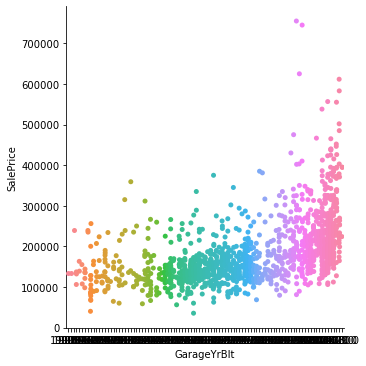

In [36]:
sns.catplot(x='GarageYrBlt',y='SalePrice',data=df)
df.GarageYrBlt.describe() 
#making bins for Garage Year Built

In [7]:
df.value_counts()
# df.LotShape.fillna(df.LotConfig.mode(),inplace=True)
# plt.bar(df.LotConfig,df.SalePrice)

Series([], dtype: int64)

<AxesSubplot:xlabel='GarageCars', ylabel='SalePrice'>

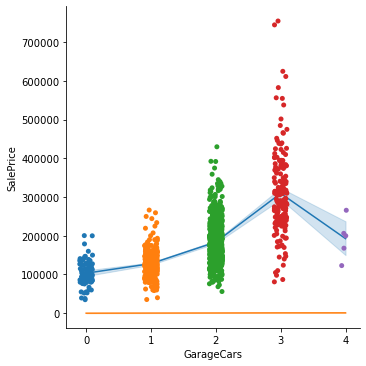

In [8]:
sns.catplot(x='GarageCars',y='SalePrice',data=df)
sns.lineplot(x='GarageCars',y='SalePrice',data=df)
sns.lineplot(x='GarageCars',y='GarageArea',data=df)
#dropping Garage Area and will use Garage Cars for the same, as both represent the same thing

In [9]:
from sklearn.linear_model import LinearRegression
sub = df[['OpenPorchSF', '3SsnPorch','ScreenPorch','EnclosedPorch']]
m1 = LinearRegression().fit(sub,df.SalePrice)
m1.score(sub,df.SalePrice)
coef = m1.coef_
inter = m1.intercept_

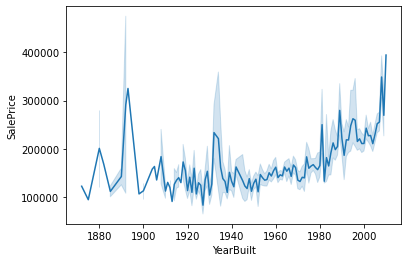

In [10]:
# sns.catplot(x='YearBuilt',y='SalePrice',data=df)
sns.lineplot(x='YearBuilt',y='SalePrice',data=df)
# sns.lineplot(x='YearBuilt',y='GarageArea',data=df)/
df['HouseYear'] = pd.cut(x=df['YearBuilt'], bins=[1872, 1910, 1950, 1980, 1990, 2002, 2010], labels=[0, 1, 2, 3, 4, 5])

In [11]:
df.corr().OverallCond # we can consider dropping this,, less correlation with Sale Price

MSSubClass      -0.059316
LotFrontage     -0.059213
LotArea         -0.005636
OverallQual     -0.091932
OverallCond      1.000000
YearBuilt       -0.375983
YearRemodAdd     0.073741
MasVnrArea      -0.128101
BsmtFinSF1      -0.046231
BsmtFinSF2       0.040229
BsmtUnfSF       -0.136841
TotalBsmtSF     -0.171098
1stFlrSF        -0.144203
2ndFlrSF         0.028942
LowQualFinSF     0.025494
GrLivArea       -0.079686
BsmtFullBath    -0.054942
BsmtHalfBath     0.117821
FullBath        -0.194149
HalfBath        -0.060769
BedroomAbvGr     0.012980
KitchenAbvGr    -0.087001
TotRmsAbvGrd    -0.057583
Fireplaces      -0.023820
GarageYrBlt     -0.324297
GarageCars      -0.185758
GarageArea      -0.151521
WoodDeckSF      -0.003334
OpenPorchSF     -0.032589
EnclosedPorch    0.070356
3SsnPorch        0.025504
ScreenPorch      0.054811
PoolArea        -0.001985
MiscVal          0.068777
MoSold          -0.003511
YrSold           0.043950
SalePrice       -0.077856
Name: OverallCond, dtype: float64

No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

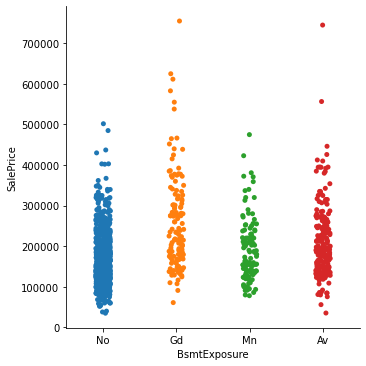

In [12]:
sns.catplot(x='BsmtExposure',y='SalePrice',data=df) # we can drop this
df.BsmtExposure.value_counts()

In [13]:
# df['BsmtFinSF'] = (df['BsmtFinSF1'] + df['BsmtFinSF2'])/2
# df.drop(['BsmtFinSF1', 'BsmtFinSF2'],axis=1,inplace=True)

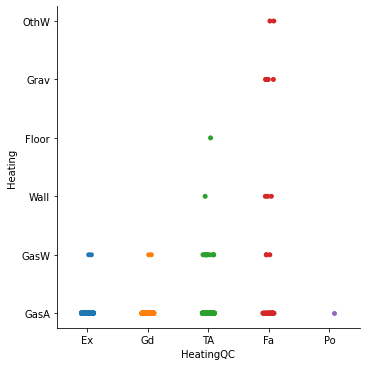

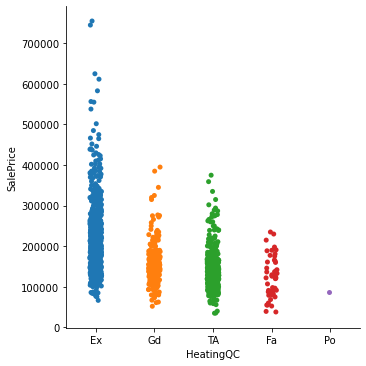

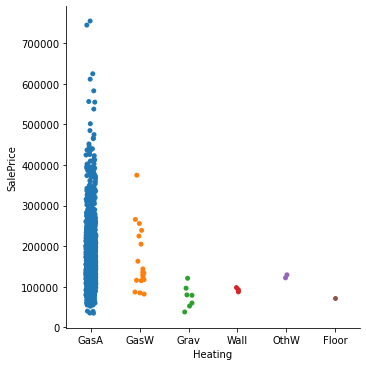

In [14]:
sns.catplot(x='HeatingQC',y='Heating',data=df)
sns.catplot(x='HeatingQC',y='SalePrice',data=df)
sns.catplot(x='Heating',y='SalePrice',data=df)

In [15]:
# from sklearn.ensemble import RandomForestRegressor
# regr = RandomForestRegressor(max_depth=2, random_state=0)
# df = prep(df)
# y = df['SalePrice']
# df.drop(['SalePrice'],axis=1,inplace=True)
# regr.fit(df, y)
# df.info()

In [16]:
# ordinal  encoding on features that require that treatment, and on rest label encoding , using for loop.

Now we will change the object type to numerical or float/int type. For this I will use label encoding and ordinal encoding, depending on the data description.
Heating --- doubt

can drop "Functional", "GarageCond", "GarageQual", "PavedDrive", "MiscFeature", "SaleType", "Utilities"

In [37]:
def prep2(df):    
    enc_df = pd.DataFrame(me.transform(df[labels]).toarray())
    df1 = df.join(enc_df)
    df1.drop(labels, axis=1,inplace=True)
    df1.fillna(0, inplace=True) # not sure abbout this
    ordinal_ch(df1)
    return df1

In [41]:
labels = ["MSZoning", "Street", "LotShape", "LandContour", "LotConfig", "Neighborhood","Condition1", "Condition2", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "GarageType", "SaleCondition"]
# labels = labels.append(["MiscFeature", 'Heating','GarageArea', 'PoolArea',"PoolQC", "Functional", "GarageCond", "GarageQual", "PavedDrive", "SaleType", "Utilities"])

ordinals = ["LandSlope", "BldgType", "HouseStyle", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "HeatingQC", "Heating", "CentralAir", "Electrical", "KitchenQual", "FireplaceQu", "GarageFinish","Fence"]

In [42]:
label_encoder = preprocessing.LabelEncoder()
enc = OneHotEncoder(handle_unknown='ignore')
me = (enc.fit(X_train[labels]))
# end_df = me.transform(df[labels]).toarray()

In [39]:
# for x in ordinals:
#     print(df[x].value_counts())
y = df['SalePrice']
df.drop(['SalePrice'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.25, random_state=42)

In [43]:
X_train = prep(X_train)
X_test = prep(X_test)
X_train = prep2(X_train)
X_test = prep2(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
<ipython-input-35-05c8f3afb429>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64
0    1382
1      65
2      13
Name: LandSlope, dtype: int64


In [44]:
regr = RandomForestRegressor(max_depth=10, random_state=42)
m1 = regr.fit(X_train,y_train)
m1.score(X_train,y_train)

ValueError: could not convert string to float: 'Grvl'

In [45]:
y_pred = np.log(m1.predict(X_test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


ValueError: Unable to convert array of bytes/strings into decimal numbers with dtype='numeric'

In [46]:
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(np.log(y_test), y_pred, squared=False)
print(rms)

NameError: name 'y_pred' is not defined

In [47]:
df = prep(df)
df_test = prep(df_test)
df = prep2(df)
df_test = prep2(df_test)

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64
0    1382
1      65
2      13
Name: LandSlope, dtype: int64


In [63]:
Y_pred = m1.predict(df_test)
submission = pd.DataFrame({
        "Id": df_test.index,
        "SalePrice": Y_pred
    })

In [64]:
submission.to_csv('submission.csv', index=False)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,HouseYear,Bath,Porch,GarageYear,BsmtFinSF
Id,,,,,,,,,,,,,,,,,,,,,
1024,120,RL,43.0,3182,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,5,2008,WD,Normal,5,2,20,5,8.0
811,20,RL,78.0,10140,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,1,2006,WD,Normal,2,3,0,2,520.0
1385,50,RL,60.0,9060,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,10,2009,WD,Normal,1,1,0,1,102.0
627,20,RL,35.0,12342,Pave,Grvl,IR1,Lvl,AllPub,Inside,...,600,8,2007,WD,Normal,2,1,0,2,0.0
814,20,RL,75.0,9750,Pave,Pave,Reg,Lvl,AllPub,Inside,...,500,4,2007,COD,Normal,2,2,0,2,304.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096,20,RL,78.0,9317,Pave,Grvl,IR1,Lvl,AllPub,Inside,...,0,3,2007,WD,Normal,5,2,22,5,12.0
1131,50,RL,65.0,7804,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,12,2009,WD,Normal,1,3,44,3,311.0
1295,20,RL,60.0,8172,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,4,2006,WD,Normal,2,2,0,2,83.5
